In [4]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import shutil
import pathlib
import re  # Regex
import time

2023-05-10 14:53:00.054209: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-10 14:53:00.098057: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data aquisition

In [2]:
#Downloading dataset
import tarfile
import urllib
import os
def download(filename, source_url, work_directory):
    if not os.path.exists(work_directory): #check if the folder exists; if not make dir
        os.mkdir(work_directory)
    filepath = os.path.join(work_directory, filename)
    if not os.path.exists(filepath): # check if file exists; if not, download
        print("Downloading file, Please wait...")
        filepath, _ = urllib.request.urlretrieve(source_url + filename, # this is a function to download files
                                                 filepath)
        statinfo = os.stat(filepath)
        print(('Succesfully downloaded', filename, statinfo.st_size, 'bytes.'))
        untar(filepath,work_directory)
    return filepath
#only extract jpg files
def jpg_files(members):
    for tarinfo in members:
        if os.path.splitext(tarinfo.name)[1] == ".jpg":
            yield tarinfo
# extract function
def untar(fname,path="17category-flowers-py"): #untarring the archive
    tar = tarfile.open(fname)
    tar.extractall(path="17category-flowers-py", members=jpg_files(tar))
    tar.close()
    if path is "":
        print("File Extracted in Current Directory")
    else:
        print("File Extracted in to ",  path)
download("17flowers.tgz", "http://www.robots.ox.ac.uk/~vgg/data/flowers/17/","17category-flowers-py")

<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\Käyttäjä\AppData\Local\Temp\ipykernel_17040\658763952.py:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if path is "":


'17category-flowers-py\\17flowers.tgz'

In [4]:
import os
os.listdir("17category-flowers-py/") 

['17flowers.tgz', 'jpg']

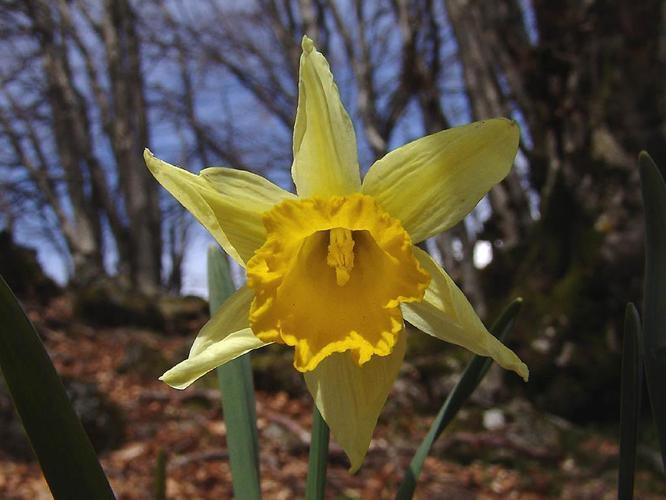

In [5]:
from PIL import Image #show one example of image
Image.open("17category-flowers-py/jpg/image_0002.jpg")

In [6]:
#load images as np arrays
import numpy as np
def load_data(fpath):    
    img=Image.open(fpath).resize((224,224)) # resize to 224x224 for training purposes
    img = np.asarray(img, dtype='float32')
    return img
#all images are loaded as np arrays
images=[]
labels=[]
total=1361
j=1
for i in range(1, total): 
    fname="17category-flowers-py/jpg/image_"    
    fpath = os.path.join(fname + str(i).zfill(4) + ".jpg")
    images.append(load_data(fpath))
    labels.append(j) #labels are created as well
    if i%80==0: j+=1
images = np.asarray(images) # all of the images are converted to np array of (1360,224,224,3)
labels = np.asarray(labels).reshape(1360,1) # labels are also converted to (1360,1)
images.shape

(1360, 224, 224, 3)

In [7]:
# split data into training and test
from sklearn.model_selection import train_test_split 
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, train_size = 0.8, random_state =  104)

c:\Users\Käyttäjä\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


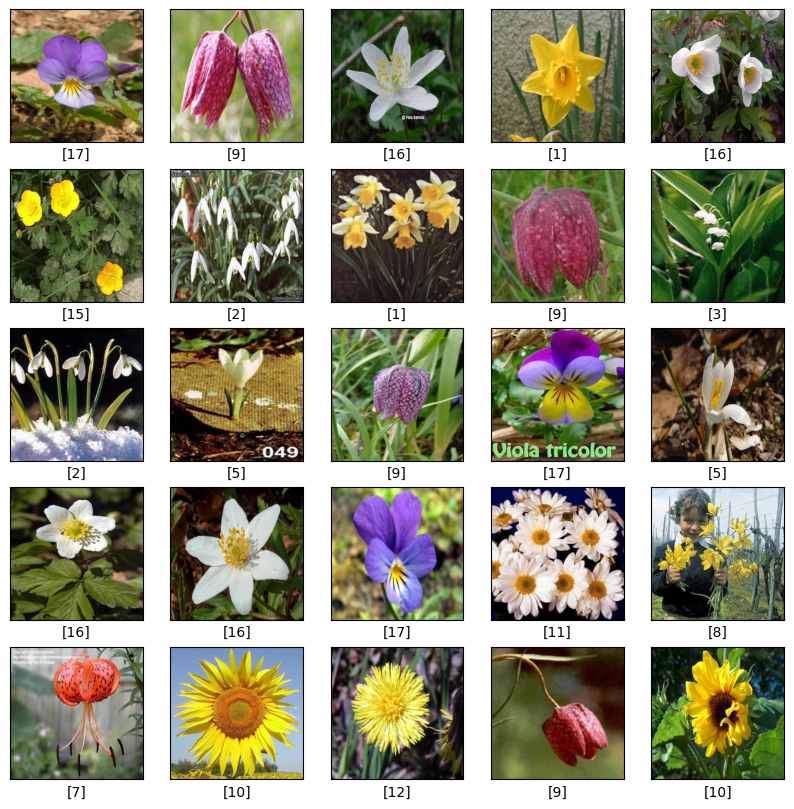

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10)) # plot 25 images
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i]/255, cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

## Preprocessing

### original version

In [9]:
# dividing images into train and test folders by creating images from arrays
import cv2
import numpy as np
def create_images(data, labels, folder):
    dirname=folder
    
    if not os.path.exists(dirname): #check if the folder exists; if not make dir
      os.mkdir(dirname)
    n=0
    
    for i in data:
      label_n=labels[n][0]
      subfolder = folder + "/" + str(label_n) 
      if not os.path.exists(subfolder): # create subfolders with categories
          os.mkdir(subfolder)  
      filepath =  subfolder + "/" + str(n)+ ".jpg"
      cv2.imwrite(filepath, data[n]) #save image to corresponding subfolders
      n+=1
create_images(train_images, train_labels, 'train') #save image to corresponding subfolders
create_images(test_images, test_labels, 'test')

In [8]:
train_dir =os.path.realpath('train')
validation_dir = os.path.realpath('test')
image_size = 224

In [ ]:
# image augmentation for train set and image resizing for validation
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( # this function will generate augmented images in real time
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255) # for validation we don't need to augment

train_batchsize = 100
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory( # this function takes images from folders and feeds to Imagedatagenerator
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

### Fabi implementation

This part will use the train/val/test splits provided in the dataseet.

In [1]:
import scipy.io
mat = scipy.io.loadmat('./data/17flowers/datasplits.mat')

image_size = 224
batch_size = 32
epochs = 50

# The image ids for each split
train_ids = mat["trn1"][0]
val_ids = mat["val1"][0]
test_ids = mat["tst1"][0]

# The amount of images in each split
train_size = len(train_ids)
val_size = len(val_ids)
test_size = len(test_ids)

print(f"Training  : {train_size} images.")
print(f"Validation: {val_size} images.")
print(f"Testing   : {test_size} images.")

Training  : 680 images.
Validation: 340 images.
Testing   : 340 images.


create the 17 subfolders for each split

In [3]:
import os
# list of class labels
with open("17flowers_labels.txt", "r") as f:
    flower_labels = [line.strip() for line in f]

# set the path to the folder containing the images
path_to_data = "data/17flowers/"

def create_subfolders(path):
    """
    Create train/val/test subfolders with 17 subfolders each (1 for each label).
    """
    for split_name in ["train/", "val/", "test/"]:
        for label in flower_labels:
            os.makedirs(path + split_name + label, exist_ok=True)
    print(f"All subfolders created at {path}.")

create_subfolders(path_to_data)

All subfolders created at data/17flowers/.


In [5]:
# move the images into the subfolders
def move_images_to_subfolders(path):
    """
    Copy images from `path/jpg` to `path` subfolders train/val/test and their labels.
    """
    src_path = path + "jpg/"
    for filename in os.listdir(src_path):
        if filename.endswith(".jpg"):
            # Get the id of the image from its filename
            
            file_id = int(re.findall(r'\d+', filename)[0])
            # file_id = int(filename[6:-4])

            # Check which split the file belongs to
            if file_id in train_ids:
                split = "train/"
            elif file_id in val_ids:
                split = "val/"
            elif file_id in test_ids:
                split = "test/"
            else:
                print(f"{filename} isn't associated with any splits.")

            # calculate the subfolder to move the image into
            subfolder_id = (file_id-1) // 80  # File ids start from 1, so subtract one. 80 images per label
            subfolder_name = path + split + flower_labels[subfolder_id]

            # move the image into the subfolder
            shutil.copy(os.path.join(src_path, filename), os.path.join(subfolder_name, filename))
    print(f"Images copied successfully to {path} test/train/val subfolders.")


move_images_to_subfolders(path_to_data)

Images copied successfully to data/17flowers/ test/train/val subfolders.


In [6]:
# Split directories
train_dir = pathlib.Path(path_to_data + "train")
val_dir = pathlib.Path(path_to_data + "val")
test_dir = pathlib.Path(path_to_data + "test")

# Image counts
train_count = len(list(train_dir.glob('*/*.jpg')))
val_count = len(list(val_dir.glob('*/*.jpg')))
test_count = len(list(test_dir.glob('*/*.jpg')))

print(f"Number of images at {path_to_data}: {train_count}/{train_size} (train), {val_count}/{val_size} (val), {test_count}/{test_size} (test)")

# The number of images in each folder should be the same as the amount of ids provided by the datasplits.mat file
assert train_count == train_size, f"Expected {train_size} images, but {train_dir} only has {train_count}"
assert val_count == val_size, f"Expected {train_size} images, but {val_dir} only has {val_count}"
assert test_count == test_size, f"Expected {train_size} images, but {test_dir} only has {test_count}"

Number of images at data/17flowers/: 680/680 (train), 340/340 (val), 340/340 (test)


In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

Found 680 images belonging to 17 classes.
Found 340 images belonging to 17 classes.
Found 340 images belonging to 17 classes.


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

## Raw vgg16 model

In [12]:
# use vgg16 pre-trained model with trainable densely connected output layer

from keras.applications import VGG16
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers except for the last layer: 
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()

# normalize the image
model.add(normalization_layer)
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(17, activation='softmax'))
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=optimizers.RMSprop(lr=2e-4), # learning rate should be small so previously learned weights don't vanish
              metrics=['accuracy'])

model.build((None, image_size, image_size, 3))
model.summary()

2023-05-10 15:00:55.025265: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


58889256/58889256 [==============================] - 29s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 17)                17425     
                                                                 
Total params: 40,423,249
Trainable params: 32,787,985
Non-trainable params: 7,635,264
____________________________________

In [14]:
# train the model with augmented images in real-time
history = model.fit_generator(
      train_ds,
      # steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs,
      validation_data=val_ds,
      # validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

/tmp/ipykernel_12997/702163703.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50


2023-05-10 15:03:10.905665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


17/21 [=======================>......] - ETA: 23s - loss: 3.0751 - accuracy: 0.0809

KeyboardInterrupt: 

In [13]:
model.save('my_model_vgg.h5')
print('training acc.:',history.history['accuracy'][-1],'\n','validation acc.:', (history.history['val_accuracy'])[-1])
print('test accuracy', model.evaluate(test_ds, verbose=0)[1])

training acc.: 0.9145220518112183 
 test acc.: 0.9227941036224365


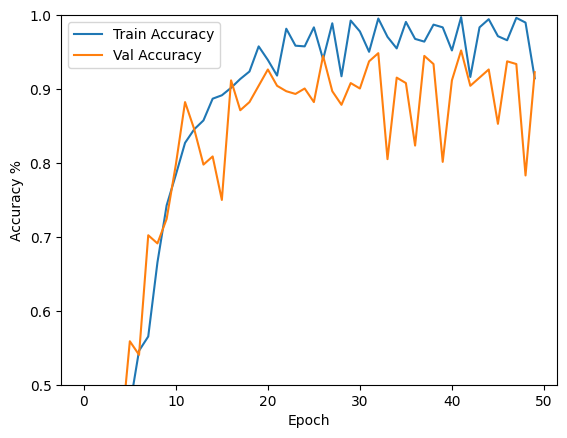

In [15]:
# plot the accuracy history
import matplotlib.pyplot as plt
def plot_history(history):
 plt.figure()
 plt.xlabel('Epoch')
 plt.ylabel('Accuracy %')
 plt.plot(history.epoch, np.array(history.history['accuracy']),
 label='Train Accuracy')
 plt.plot(history.epoch, np.array(history.history['val_accuracy']),
 label = 'Val Accuracy')
 plt.legend()
 plt.ylim([0.5, 1])
plot_history(history)

## CC gray world


CC from Keras Layers

In [14]:

from keras.applications import VGG16
from processing.grey_world.cc_layers import GreyWorld
from keras import models
from keras import layers
from keras import optimizers
 
# Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers except for the last layer: 
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Create the model
model = models.Sequential()

# Add the grey_world_layer
grey_world_layer = GreyWorld()
model.add(grey_world_layer)
 
# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(17, activation='softmax'))
 
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-4),
              metrics=['acc', 'top_k_categorical_accuracy'])

# Build the model
model.build((None, image_size, image_size, 3))

# Print the model summary
model.summary()

# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)


c:\Users\Käyttäjä\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Käyttäjä\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grey_world (GreyWorld)      (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              25691136  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 17)                17425     
                                                                 
Total params: 40,423,249
Trainable params: 32,787,985


C:\Users\Käyttäjä\AppData\Local\Temp\ipykernel_17040\4107281624.py:42: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
10/10 [==============================] - 109s 10s/step - loss: 3.2158 - acc: 0.0607 - top_k_categorical_accuracy: 0.3134 - val_loss: 2.8368 - val_acc: 0.0699 - val_top_k_categorical_accuracy: 0.3125
Epoch 2/50
10/10 [==============================] - 104s 10s/step - loss: 2.7628 - acc: 0.1048 - top_k_categorical_accuracy: 0.4136 - val_loss: 2.5532 - val_acc: 0.1654 - val_top_k_categorical_accuracy: 0.5772
Epoch 3/50
10/10 [==============================] - 103s 10s/step - loss: 2.5550 - acc: 0.1544 - top_k_categorical_accuracy: 0.5221 - val_loss: 2.2955 - val_acc: 0.2794 - val_top_k_categorical_accuracy: 0.6691
Epoch 4/50
10/10 [==============================] - 103s 10s/step - loss: 2.3917 - acc: 0.2178 - top_k_categorical_accuracy: 0.5864 - val_loss: 2.1091 - val_acc: 0.3051 - val_top_k_categorical_accuracy: 0.7059
Epoch 5/50
10/10 [==============================] - 106s 10s/step - loss: 2.1302 - acc: 0.3033 - top_k_categorical_accuracy: 0.6921 - val_loss: 1.9122 - val_acc

In [15]:

print('training acc.:',history.history['acc'][-1],'\n','test acc.:', (history.history['val_acc'])[-1])
print('training top 5:',history.history['top_k_categorical_accuracy'][-1], '\n', 'val top 5:', history.history['val_top_k_categorical_accuracy'][-1], '\n')


training acc.: 0.9972426295280457 
 test acc.: 0.9522058963775635
training top 5: 0.9990808963775635 
 val top 5: 0.9963235259056091 



## gray edge

In [16]:
from keras.applications import VGG16
from processing.grey_world.cc_layers import GreyEdge
from keras import models
from keras import layers
from keras import optimizers
 
# Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers except for the last layer: 
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Create the model
model = models.Sequential()

# Add the white_patch_layer
grey_edge_layer = GreyEdge()
model.add(grey_edge_layer)
 
# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(17, activation='softmax'))
 
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-4),
              metrics=['acc', 'top_k_categorical_accuracy'])

# Build the model
model.build((None, image_size, image_size, 3))

# Print the model summary
model.summary()

# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grey_edge (GreyEdge)        (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 1024)              25691136  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 17)                17425     
                                                                 
Total params: 40,423,249
Trainable params: 32,787,985


C:\Users\Käyttäjä\AppData\Local\Temp\ipykernel_17040\3759703775.py:42: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
10/10 [==============================] - 128s 12s/step - loss: 3.0985 - acc: 0.0708 - top_k_categorical_accuracy: 0.3336 - val_loss: 2.7067 - val_acc: 0.1213 - val_top_k_categorical_accuracy: 0.4191
Epoch 2/50
10/10 [==============================] - 126s 12s/step - loss: 2.7538 - acc: 0.1121 - top_k_categorical_accuracy: 0.3732 - val_loss: 2.5480 - val_acc: 0.2316 - val_top_k_categorical_accuracy: 0.5000
Epoch 3/50
10/10 [==============================] - 127s 12s/step - loss: 2.4062 - acc: 0.2132 - top_k_categorical_accuracy: 0.5331 - val_loss: 2.5709 - val_acc: 0.2316 - val_top_k_categorical_accuracy: 0.5956
Epoch 4/50
10/10 [==============================] - 127s 12s/step - loss: 2.1998 - acc: 0.2923 - top_k_categorical_accuracy: 0.6664 - val_loss: 1.9876 - val_acc: 0.4007 - val_top_k_categorical_accuracy: 0.8346
Epoch 5/50
10/10 [==============================] - 127s 12s/step - loss: 2.0171 - acc: 0.3235 - top_k_categorical_accuracy: 0.7077 - val_loss: 2.0115 - val_acc

In [17]:

print('training acc.:',history.history['acc'][-1],'\n','test acc.:', (history.history['val_acc'])[-1])
print('training top 5:',history.history['top_k_categorical_accuracy'][-1], '\n', 'val top 5:', history.history['val_top_k_categorical_accuracy'][-1], '\n')


training acc.: 0.9963235259056091 
 test acc.: 0.9448529481887817
training top 5: 1.0 
 val top 5: 0.9963235259056091 



## White patch

In [18]:
from keras.applications import VGG16
from processing.grey_world.cc_layers import WhitePatch
from keras import models
from keras import layers
from keras import optimizers
 
# Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers except for the last layer: 
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Create the model
model = models.Sequential()

# Add the white_patch_layer
white_patch_layer = WhitePatch()
model.add(white_patch_layer)
 
# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(17, activation='softmax'))
 
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-4),
              metrics=['acc', 'top_k_categorical_accuracy'])

# Build the model
model.build((None, image_size, image_size, 3))

# Print the model summary
model.summary()

# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 white_patch (WhitePatch)    (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              25691136  
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 17)                17425     
                                                                 
Total params: 40,423,249
Trainable params: 32,787,985


C:\Users\Käyttäjä\AppData\Local\Temp\ipykernel_17040\1094997165.py:42: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
10/10 [==============================] - 113s 10s/step - loss: 3.0190 - acc: 0.0882 - top_k_categorical_accuracy: 0.3392 - val_loss: 2.8598 - val_acc: 0.0956 - val_top_k_categorical_accuracy: 0.3676
Epoch 2/50
10/10 [==============================] - 104s 10s/step - loss: 2.7151 - acc: 0.1314 - top_k_categorical_accuracy: 0.4311 - val_loss: 2.5350 - val_acc: 0.1618 - val_top_k_categorical_accuracy: 0.5368
Epoch 3/50
10/10 [==============================] - 104s 10s/step - loss: 2.4190 - acc: 0.2261 - top_k_categorical_accuracy: 0.5735 - val_loss: 1.9744 - val_acc: 0.3419 - val_top_k_categorical_accuracy: 0.7941
Epoch 4/50
10/10 [==============================] - 105s 10s/step - loss: 2.0361 - acc: 0.3263 - top_k_categorical_accuracy: 0.7279 - val_loss: 1.7037 - val_acc: 0.4301 - val_top_k_categorical_accuracy: 0.8015
Epoch 5/50
10/10 [==============================] - 105s 10s/step - loss: 1.7037 - acc: 0.4393 - top_k_categorical_accuracy: 0.7950 - val_loss: 1.7693 - val_acc

In [19]:

print('training acc.:',history.history['acc'][-1],'\n','test acc.:', (history.history['val_acc'])[-1])
print('training top 5:',history.history['top_k_categorical_accuracy'][-1], '\n', 'val top 5:', history.history['val_top_k_categorical_accuracy'][-1], '\n')


training acc.: 0.998161792755127 
 test acc.: 0.9558823704719543
training top 5: 1.0 
 val top 5: 0.9926470518112183 



## Base model function

### base model for cc models

In [ ]:
from keras.applications import VGG16
from processing.grey_world.cc_layers import WhitePatch
from keras import models
from keras import layers
from keras import optimizers
 

def ccModel(cc_layers):
    # Load the VGG model
    vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    # Freeze all the layers except for the last layer: 
    for layer in vgg_conv.layers[:-4]:
        layer.trainable = False
    
    # Create the model
    model = models.Sequential()

    if cc_layers == None:
        model.add(tf.keras.layers.Rescaling(1./255))
    else:
        # Add cc layers
        model.add(cc_layers)
    
    # Add the vgg convolutional base model
    model.add(vgg_conv)

    # Add new layers
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(17, activation='softmax'))
    
    # Compile the model
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=optimizers.RMSprop(lr=2e-4),
                metrics=['accuracy'])

    # Build the model
    model.build((None, image_size, image_size, 3))
    
    return model

In [ ]:
import time

def experiment(model, train_ds, val_ds, test_ds, n_trials=10):
    metrics = {
        "train_time": [],
        "test_time": [],
        "train_acc": [],
        "train_loss": [],
        "val_acc": [],
        "val_loss": [],
        "test_acc": [],
        "test_loss": [],
        "history": []
    }

    for i in range(n_trials):        
        model.compile(
            optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

        start_time = time.perf_counter()
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=[reduce_lr, early_stop],
            verbose=0)
        end_time = time.perf_counter()
        training_time = end_time - start_time

        start_time = time.perf_counter()
        test_loss, test_acc = model.evaluate(test_ds, verbose=0)
        end_time = time.perf_counter()
        test_time = end_time - start_time

        metrics["train_time"].append(training_time)
        metrics["test_time"].append(test_time)
        metrics["train_acc"].append(history.history["accuracy"][-1])
        metrics["train_loss"].append(history.history["loss"][-1])
        metrics["val_acc"].append(history.history["val_accuracy"][-1])
        metrics["val_loss"].append(history.history["val_loss"][-1])
        metrics["test_acc"].append(test_acc)
        metrics["test_loss"].append(test_loss)
        metrics["history"].append(history)
    return metrics

### Experiments

In [ ]:
from processing.grey_world.cc_layers import GreyWorld, WhitePatch, GreyEdge

grey_world_layer = GreyWorld()
white_patch_layer = WhitePatch()
grey_edge_layer = GreyEdge()

# Create new models
model_base = ccModel()
# model_batch = get_model_batchnorm()
model_gw = ccModel(grey_world_layer)
model_ge = ccModel(grey_edge_layer)
model_wp = ccModel(white_patch_layer)
# model_fc4 = ccModel()

# Run experiments
n_trials = 1
metrics = {}
metrics["Base"] = experiment(model_base, train_ds, val_ds, test_ds, n_trials=n_trials)
# metrics["BatchNorm"] = experiment(model_batch, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics["GreyWorld"] = experiment(model_gw, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics["GreyEdge"] = experiment(model_ge, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics["WhitePatch"] = experiment(model_wp, train_ds, val_ds, test_ds, n_trials=n_trials)
# metrics["FC4"] = experiment(model_fc4, train_ds_cc, val_ds_cc, test_ds_cc, n_trials=n_trials)

### Saving the results

In [ ]:
import pandas as pd
import datetime
# Get the current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H-%M-%S")

# Export data to Excel sheet
dst_path = f"./out/{timestamp}_experiments_17flowers.xlsx"
with pd.ExcelWriter(dst_path, engine='xlsxwriter',) as writer:
    end_data = pd.concat({k: pd.DataFrame(v) for k, v in metrics.items()}, axis=0, names=["Algorithm", "Trial"])
    end_data.drop("history", axis=1, inplace=True)
    end_data.to_excel(writer, "Final Data", merge_cells=False)

    for k, metric in metrics.items():
        histories = metric["history"]
        algo_data = pd.concat({f"{i}": pd.DataFrame(history.history) for i, history in enumerate(histories)}, axis=1)
        algo_data.to_excel(writer, f"{k} History", merge_cells=False)

print(f"Data saved to {dst_path}")
